In [1]:
'''
Available methods are the followings:
[1] create_schedule
[2] gantt_plot
[3] workingdays

Authors: Danusorn Sitdhirasdr <danusorn.si@gmail.com>
versionadded:: 21-04-2022

'''
import pandas as pd, numpy as np, sys
from pandas import Timestamp
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import(FixedLocator, 
                              FixedFormatter, 
                              StrMethodFormatter,
                              FuncFormatter)
from matplotlib.patches import Patch
from datetime import date

# Adding fonts
from matplotlib import font_manager
paths = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
for font_path in paths:
    if font_path.find("Hiragino Sans GB W3")>-1: 
        try:
            font_manager.fontManager.addfont(font_path)
            prop = font_manager.FontProperties(fname=font_path)
            plt.rcParams['font.family'] = 'sans-serif'
            plt.rcParams['font.sans-serif'] = prop.get_name()
            plt.rcParams.update({'font.family':'sans-serif'})
            plt.rcParams.update({'font.sans-serif':prop.get_name()})
            plt.rc('axes', unicode_minus=False)
            break
        except:pass

__all__ = ["create_schedule", "gantt_plot", "workingdays"]

In [2]:
def create_schedule(schedule, ref_date=None, holidays=None):
    
    '''
    Create schedule DataFrame.
    
    Parameters
    ----------
    schedule : pd.DataFrame object
        A DataFrame with the following columns:
        
        Column      Dtype           Description         
        ------      -----           -----------    
        task        object          Task name
        start       datetime64[ns]  Starting date
        end         datetime64[ns]  Ending date
        completion  float64         Percent completion (actual)
    
    ref_date : str, default=None
        The reference date to be benchmarked against all tasks. If 
        None, it defaults to today's date.
        
    holidays : array_like of datetime64[D], optional
        An array of dates to consider as invalid dates. They may be 
        specified in any order, and NaT (not-a-time) dates are ignored.
        
    Returns
    -------
    X : pd.DataFrame object
        A DataFrame with the following columns:
   
        Column      Dtype           Description
        ------      -----           -----------
        task        object          Task name
        start       datetime64[ns]  Starting date
        end         datetime64[ns]  Ending date
        completion  float64         Percent completion (actual)
        start_num   int64           Starting index
        end_num     int64           Ending index
        duration    int64           Duration in day(s)
        busday      int64           Number of business days
        prog_day    float64         Actual progress in day(s)
        exp_day     int64           Expected progress in day(s)
        plan        float64         Percent completion (expected)
        diff_pct    float64         Difference in percent completion
        diff_day    float64         Difference in days
        status      object          Task status
    
    '''
    
    # ===============================================================
    X = pd.DataFrame(schedule).copy()
    # Default of ref_date is today().
    if ref_date is None: ref_date = Timestamp(date.today())
    ref_date = Timestamp(ref_date)
    # ---------------------------------------------------------------
    # Starting and ending dates
    start_date = X["start"].min()
    end_date = X["end"].max()
    # ---------------------------------------------------------------
    # Number of days from project start to start of tasks
    X['start_num'] = (X["start"] - start_date).dt.days
    # Number of days from project start to end of tasks
    X['end_num'] = (X["end"] - start_date).dt.days
    # Number of days between start and end of each task
    X['duration'] = X["end_num"] - X["start_num"]
    # Number of business days
    X['busday'] = [len(workingdays(X["start"][n], 
                                   X["end"][n], holidays)) 
                   for n in range(len(X))]
    # ---------------------------------------------------------------
    # Working days between start and current progression of each task
    X['prog_day'] = (X["duration"] * X["completion"])
    exp_day = np.fmin(np.fmax((ref_date-X["start"]).dt.days,0),
                      X["duration"])
    X["exp_day"] = exp_day
    X["plan"] = exp_day/np.fmax(X["duration"],1)
    # ---------------------------------------------------------------
    # Difference between actual and plan
    # (-) : behind schedule
    # (+) : on-time or ahead of schedule
    X["diff_pct"] = X["completion"] - X['plan'] # <-- % diff
    X["diff_day"] = X["prog_day"] - X["exp_day"] # <-- day diff
    # ---------------------------------------------------------------
    # Task status
    status = np.where(X["plan"] > X["completion"], "delay", 
                      np.where(X["completion"]==1,
                               "complete","on-time"))
    X["status"] = np.where(X["duration"]==0,"event",status)
    # ===============================================================

    return X.copy()

In [3]:
def split_char(string, length, n_lines=2, suffix=" ..."):
    
    '''Private Function: split string of words into lines'''
    lines = []
    split2w = np.r_[string.lstrip().rstrip().split(" ")]
    while len(split2w)>0:
        index = np.r_[[len(word) for word in split2w]]
        index = np.cumsum(index)<=length
        lines += [" ".join(split2w[index])]
        split2w = split2w[~index]
        if len(lines)==n_lines: 
            if len(split2w)>0: lines[-1] += suffix
            break
    return lines

In [49]:
def gantt_plot(schedule, ax=None, ref_date=None ,colors=None, 
               major_locator=3, minor_locator=1, char_length=20, 
               tight_layout=True, holidays=None, show_delta=False, 
               show_vline=True, show_hline=True, show_days=True, 
               start_date=None, end_date=None):
    
    '''
    Gantt Chart
    
    Parameters
    ----------
    schedule : pd.DataFrame object
        An output from `create_schedule` function.
    
    ax : Matplotlib axis object, default=None
        Predefined Matplotlib axis. If None, it uses default size.
        
    ref_date : str, default=None
        The reference date to be benchmarked against all tasks. If
        None, it defaults to today's date.
        
    colors : array-like of shape (n_labels,), default=None
        List of color-hex must be arranged in correspond to following 
        labels i.e. ["complete", "on-time", "delay", "event", 
        "holidays"]. If None, it uses default colors from Matplotlib.
        
    major_locator : int, default=3
        A number of date intervals (major ticks) to be displayed on 
        x-axis. 
        
    minor_locator : int, default=1
        A number of intervals with minor ticks on x-axis.
        
    char_length : int, default=20
        A length of characters (task) to be displayed with in 2 lines.

    tight_layout : bool, default=True
        If True, it adjusts the padding between and around subplots i.e. 
        plt.tight_layout().
        
    holidays : list of str, default=None
        A list of public or special holiday dates in `str` format i.e.
        ["2022-01-01"].
        
    show_delta : boolean, default=None
        If True, it displays differences between acutal and expected
        progress of tasks, whose status is either "delay" or "on-time".
        
    show_vline : bool, default=True
        If True, it displays minor gridlines on x-axis.
    
    show_hline : bool, default=True
        If True, it display minor gridlines on y-axis.
    
    show_days : bool, default=True
        If True, it displays a number of business days and duration
        underneath percent completion e.g. (8/10).
    
    Returns
    -------
    ax : Matplotlib axis object
    
    '''
    # Initialize default parameters
    # ===============================================================
    X = schedule.reset_index(drop=True).copy()
    n_tasks = len(X)
    # ---------------------------------------------------------------
    # Convert to datetime64
    X[["start","end"]] = X[["start", "end"]].apply(pd.to_datetime)
    min_date, max_date = X["start"].min(), X["end"].max()
    # ---------------------------------------------------------------
    # Starting date
    if start_date is None: start_date = X["start"].min()
    start_date = max(Timestamp(start_date), min_date)
    # --------------------------------------------------------------
    # Ending date
    if end_date is None: end_date = X["end"].max()
    end_date = min(Timestamp(end_date), max_date)
    # --------------------------------------------------------------
    # Validate: end_date > start_date
    if end_date <= start_date:
        raise ValueError(f"`end_date` must be greater than" 
                         f"`start_date`. Got `end_date` "
                         f"({end_date.date()}) <= `start_date " 
                         f"({start_date.date()}).")
    # --------------------------------------------------------------
    # Number of periods and date range.
    dates = pd.date_range(min_date, max_date+np.timedelta64(1,'D'))
    # Determine x_min, and x_max
    indices = np.isin(dates, [start_date, end_date])
    x_min, x_max = np.arange(len(dates))[indices]
    # ---------------------------------------------------------------
    # Default axis
    if ax is None:
        height = max(n_tasks*0.45, 4.5)
        width  = max((x_max - x_min + 2)*0.3 + 1, 12)
        ax = plt.subplots(figsize=(width, height))[1]
    # ---------------------------------------------------------------
    # Default of ref_date is today().
    if ref_date is None: ref_date = Timestamp(date.today())
    ref_date = Timestamp(ref_date)
    if colors is None:
        colors = ["#3498db","#2ecc71","#e74c3c","#2C3A47","#25CCF7"]
    major_locator = max(1, major_locator)
    minor_locator = max(1, minor_locator)
    # ---------------------------------------------------------------
    if holidays is not None:
        # Convert string date to datetime64.
        holidays = pd.Series([Timestamp(t) for t in holidays])
    # ===============================================================

    # Gantt chart
    # ===============================================================
    y, patches, labels, = np.arange(n_tasks), [], []
    status = ["complete", "on-time", "delay", "event"]
    for i,s in enumerate(status):
        index = X["status"]==s
        if (sum(index)>0) & (s!="event"):
            # Expected number of days.
            args = (y[index], X["exp_day"][index])
            kwds = dict(left=X["start_num"][index], height=0.7, 
                        color=colors[i], zorder=1, alpha=0.4)
            ax.barh(*args, **kwds)
            # Actual progress
            args = (y[index], X["prog_day"][index])
            kwds = dict(left=X["start_num"][index], height=0.7, 
                        color=colors[i], zorder=2)
            ax.barh(*args, **kwds)
        elif  (sum(index)>0) & (s=="event"):
            kwds = dict(c=colors[i], zorder=2, marker="D", s=50)
            ax.scatter(X["start_num"][index], y[index], **kwds)
    # ---------------------------------------------------------------          
        labels += [s[0].upper() + s[1:] + 
                   " ({:,d})".format(sum(index))]
        if s=="event": 
            legend_kwds = dict(marker="D", markersize=5, 
                               markerfacecolor=colors[-2], 
                               markeredgecolor="none",
                               color='none') 
            patches += [mpl.lines.Line2D([0],[0], **legend_kwds)]
        else: patches += [Patch(facecolor=colors[i])]
    # ---------------------------------------------------------------
    # Facecolor
    index = X["status"]!="event"
    ax.barh(y[index], X["duration"][index], left=X["start_num"][index], 
            alpha=0.5, facecolor="grey", height=0.7, edgecolor="none",
            zorder=1)
    # ---------------------------------------------------------------
    kwds = dict(facecolor="none", height=0.7, zorder=3, lw=1)
    delay = [(X["status"]!="delay") & (X["status"]!="event"),
             (X["status"]=="delay")]
    for index,ec in zip(delay, ["#636e72","#e74c3c"]):
        if sum(index)>0:
            args = (y[index], X["duration"][index])
            kwds.update({"left":X["start_num"][index],"edgecolor":ec})
            ax.barh(*args, **kwds)
    # ===============================================================

    # Task, and % progress
    # ===============================================================
    kwds = dict(textcoords='offset points', va="center", fontsize=10.5, 
                color="k", bbox=dict(boxstyle='round', facecolor="w", 
                                     pad=0.1, edgecolor="none"))
    r_text = {**kwds, **dict(ha="left" , xytext=(+3,0))}
    l_text = {**kwds, **dict(ha="right", xytext=(-3,0))}
    # ---------------------------------------------------------------            
    for n in range(n_tasks):
        if X["status"][n]!="event":
            s = "{:.0%}".format( X["completion"][n])
            if (X["status"][n]!="complete") & show_delta:
                diff = X["diff_pct"][n]
                if diff!=0:s += " ({:+,.0%})".format(diff)
            if show_days:
                a = (X["busday"][n], X["duration"][n])
                s = "\n".join((s,"({:,d}/{:,d})".format(*a))) 
            ax.annotate(s,(X["end_num"][n],n), **r_text)
            s = "\n".join(split_char(X["task"][n], char_length))
            i = min(max(X["start_num"][n], x_min), x_max)
            ax.annotate(s, (i,n),**l_text)
        else: 
            s = split_char(X["task"][n], char_length)
            i = min(max(X["start_num"][n], x_min), x_max)
            ax.annotate("\n".join(s), (i,n),
                        **{**l_text,**dict(xytext=(-10,0))})
    # ===============================================================    

    # Set other attributes
    # ===============================================================
    ax.set_yticks(y)
    ax.set_yticklabels([])
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(axis='y', length=0)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
    ax.tick_params(axis='both', labelsize=12)
    ax.set_ylim(-0.5,max(y)+0.5)
    # ---------------------------------------------------------------
    # X-ticks
    xticks = np.arange(0, len(dates), major_locator)
    xticks_minor = np.arange(0, len(dates), minor_locator)
    # ---------------------------------------------------------------
    ax.set_xticks(xticks)
    ax.set_xticks(xticks_minor, minor=True)
    ax.set_xticklabels(dates.strftime("%d/%m")[::major_locator], 
                       color='k')
    # ax.set_xlim(-1, max(xticks_minor)+1)
    ax.set_xlim(x_min, x_max)
    # ===============================================================

    # Vertival spans & reference date
    # ===============================================================
    # Weekends
    xticks = np.arange(0, len(dates), 1)
    for n in xticks[dates.dayofweek>=5]:
        ax.axvspan(n, n+1, zorder=-1, facecolor="grey", 
                   edgecolor="none", alpha=0.1)
    # ---------------------------------------------------------------
    # Holidays
    ref_x = xticks[np.isin(dates, holidays)]
    if len(ref_x)>0:
        for n in ref_x:
            ax.axvspan(n, n+1, zorder=-1, alpha=0.2, 
                       facecolor=colors[4], edgecolor="none")
    labels += ["Weekends", 'Holidays']
    patches += [Patch(facecolor='grey', alpha=0.1),
                Patch(facecolor=colors[4], alpha=0.2)]
    # ---------------------------------------------------------------
    # Reference date.
    kwds = dict(textcoords='offset points', va="bottom", ha="center", 
                fontsize=13, xytext=(0,3), color="k", fontweight=600)
    ref_x = xticks[np.isin(dates, ref_date)]
    if len(ref_x)>0:
        line = ax.axvline(ref_x, zorder=-1, lw=1, c="grey", ls="--")
        ax.annotate(Timestamp(ref_date).strftime("%d/%m")
                    ,(ref_x, n_tasks-0.5), **kwds)
        labels += ["Reference date"]
        patches += [line]
    # ---------------------------------------------------------------
    # Show vertical lines
    if show_vline:
        for n in np.arange(*ax.get_xlim(), minor_locator):
            ax.axvline(n, color="#bbbbbb", linestyle="--", lw=0.5, 
                       zorder=-1)
    # ---------------------------------------------------------------
    # Show horizontal lines
    if show_hline:
        for n in np.arange(*ax.get_ylim())+1:
            ax.axhline(n, color="#bbbbbb", linestyle="--", lw=0.5, 
                       zorder=-1)
    # ===============================================================

    # Legends
    # ===============================================================
    legend = ax.legend(patches, labels, edgecolor="none", ncol=1,
                       borderaxespad=0.25, markerscale=1.5, 
                       columnspacing=0.3, labelspacing=0.7, 
                       handletextpad=0.5, prop=dict(size=12), 
                       loc='center left', facecolor="w") 
    legend.set_bbox_to_anchor([1.01, 0.5], transform = ax.transAxes)
    if tight_layout: plt.tight_layout()
    # ===============================================================

    return ax

In [5]:
def workingdays(start, end, holidays=None):
    
    '''
    Calculates which of the given dates are valid business days, and 
    which are not.
    
    Parameters
    ----------
    start, end : datetime64[D] or str
        Starting and ending dates e.g. "1999-12-25" (25th of December 
        1999).
    
    holidays : array_like of datetime64[D], optional
        An array of dates to consider as invalid dates. They may be 
        specified in any order, and NaT (not-a-time) dates are ignored. 
    
    Returns
    -------
    busday : array_like of datetime64[D]
        An array of valid business days.
    
    '''
    dates = np.arange(start, end, dtype="datetime64[D]")
    if holidays is None: holidays = np.r_[np.datetime64('nat')]
    holidays = np.array(holidays, dtype="datetime64[D]")
    busday = dates[np.is_busday(dates, holidays=holidays)]
    return busday

### Google.colab
Only execute this cell when use on google colab platform (colab).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="http://github.com/Nak007/charts"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
# Mount with google drive.
from google.colab import drive
drive.mount('/content/dirve')

# Import other libraries required.
# All *.py will be stored under the following 
# location i.e. '/content/charts'.
!git clone 'http://github.com/Nak007/charts.git'

In [6]:
# Import libraries.
import pandas as pd, numpy as np
from pandas import Timestamp
from ipywidgets import interact, fixed
from Gantt_plot import *

pd.options.display.float_format = '{:,.3f}'.format

## Examples

In [7]:
# Schedule
df = pd.read_excel('work_schedule.xlsm', sheet_name="Schedule").drop(columns=["start_date","days"])
# Holidays
holidays = pd.read_excel('work_schedule.xlsm', sheet_name="PublicHolidays").drop(columns=["Holiday"])
holidays = np.array(holidays, dtype="datetime64[D]").ravel()

In [12]:
ref_date = Timestamp(2022,3,1)
X = create_schedule(df.copy(), ref_date, holidays)
X = X.sort_values(by="start", ascending=False).reset_index(drop=True)

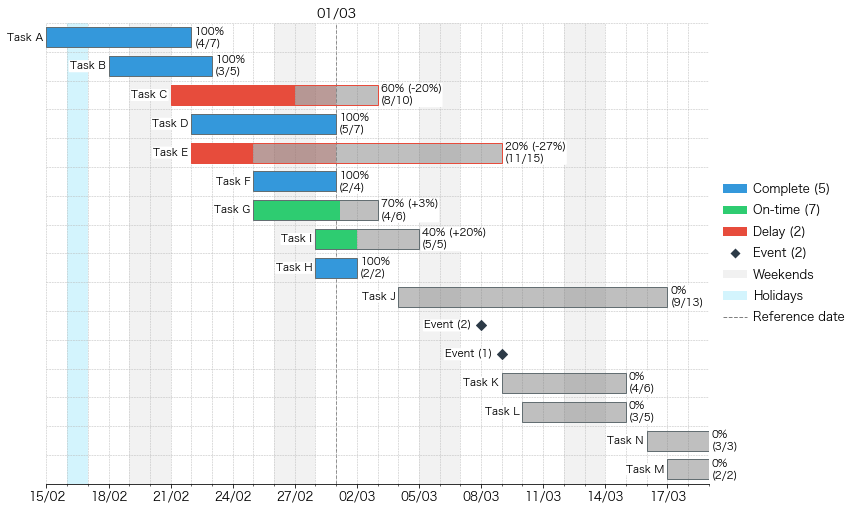

In [50]:
ax = gantt_plot(X, ref_date=ref_date, holidays=holidays, show_delta=True, 
                show_vline=True, show_hline=True, show_days=True)

In [31]:
def interactive_gantt(df, ref_date, major_locator, holidays, 
                      show_delta, start_date, end_date):
    X = create_schedule(df.copy(), ref_date, holidays=holidays)
    X = X.sort_values(by="start", ascending=False).reset_index(drop=True)
    colors = ["#1B9CFC","#55E6C1","#FC427B","#82589F","#FEA47F"]
    ax = gantt_plot(X, ref_date=ref_date, holidays=holidays, 
                    major_locator=major_locator, 
                    show_delta=show_delta, colors=colors, 
                    start_date=start_date, end_date=end_date)

In [52]:
busday = workingdays(X["start"].min(), X["end"].max())
dates  = np.arange(X["start"].min(), X["end"].max()+
                   np.timedelta64(1,'D'), dtype="datetime64[D]")
kwargs = dict(df=fixed(df), major_locator = [3,4,5,6,7],
              ref_date=busday, show_delta=[False, True], 
              holidays=fixed(holidays), 
              start_date=dates, end_date=dates[::-1])
ax = interact(interactive_gantt, **kwargs)

interactive(children=(Dropdown(description='ref_date', options=(numpy.datetime64('2022-02-15'), numpy.datetime…

In [13]:
df.columns

Index(['type', 'task', 'description', 'deliverables', 'completion', 'start',
       'end', 'member1', 'member2', 'member3'],
      dtype='object')

In [72]:
a = df[['task', 'start','end', 'member1', 'member2', 'member3']].copy()
c = np.r_[]

In [73]:
a["n_hours"] = 6/a[c].sum(axis=1)
a

,task,start,end,member1,member2,member3,n_hours
0,Task M,2022-03-17,2022-03-19,0,0,1,6.000
1,Task N,2022-03-16,2022-03-19,1,1,1,2.000
2,Task L,2022-03-10,2022-03-15,0,1,0,6.000
3,Task K,2022-03-09,2022-03-15,1,0,0,6.000
4,Task J,2022-03-04,2022-03-17,1,0,0,6.000
5,Task H,2022-02-28,2022-03-02,0,1,0,6.000
6,Task I,2022-02-28,2022-03-05,1,0,1,3.000
7,Task G,2022-02-25,2022-03-03,0,1,0,6.000
8,Task F,2022-02-25,2022-03-01,0,1,1,3.000
9,Task E,2022-02-22,2022-03-09,1,1,0,3.000


In [91]:
def get_workload(X, resources, holidays=None):
    
    '''
    Parameters
    ----------
    X : pd.DataFrame object
        A DataFrame with the following columns:

        Column      Dtype           Description
        ------      -----           -----------    
        task        object          Task name
        start       datetime64[ns]  Starting date
        end         datetime64[ns]  Ending date
        n_hours     float64         Working hours/person
        resources   int64           Responsible persons
    
    Returns
    -------
    workloads : dict
    
    '''
    # Valid business days
    busdays = workingdays(X["start"].min(), X["end"].max(), holidays)
    
    # Initialize parameters
    dtype = "datetime64[D]"
    start = np.array(X["start"], dtype=dtype)
    end   = np.array(X["end"]  , dtype=dtype)
    hours = X["n_hours"].values.copy()
    tasks = X["task"].values.copy()
    resps = X[resources].values.copy() 
    rescs = np.array(resources)
    workloads = dict([(r,{}) for r in rescs])
    
    for n in range(len(tasks)):
        
        # Working hours given task
        task = workingdays(start[n], end[n], holidays)
        work = hours[n] * np.isin(busdays, task) 
        
        # Assign working hours to responsible person(s)
        workforces = rescs[resps[n,:]==1]
        if len(workforces) > 0:
            for w in workforces:
                workloads[w].update({tasks[n]:work})
    
    return workload

In [92]:
f = get_workload(a, ['member1', 'member2', 'member3'], holidays)

In [93]:
f

{'member1': {'Task N': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 2., 2., 2.]),
  'Task K': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6., 6.,
         6., 6., 0., 0., 0., 0.]),
  'Task J': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6., 6., 6., 6., 6.,
         6., 6., 6., 6., 0., 0.]),
  'Task I': array([0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3., 3., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]),
  'Task E': array([0., 0., 0., 0., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 0., 0.,
         0., 0., 0., 0., 0., 0.]),
  'Task D': array([0., 0., 0., 0., 3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]),
  'Task C': array([0., 0., 0., 3., 3., 3., 3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]),
  'Task A': array([3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]),
  'Event (1)'

In [65]:
np.mean(pd.DataFrame(workload["member3"]).T.values.sum(axis=0)/8)

0.375

In [90]:
np.array(list(f["member1"].values())).sum(axis=0)

array([ 3.,  3.,  3.,  6.,  9.,  9.,  9.,  9., 12.,  9.,  9.,  6., 12.,
        9.,  9., 12., 12., 12., 12.,  6.,  8.,  2.,  2.])

In [94]:
1500/30

50.0